
# Ho-Lee Model: Explanation and Formulas

## **Introduction**
The Ho-Lee model is a **no-arbitrage model** used for modeling interest rates. It assumes that the short rate evolves as:

$$ dr_t = \theta(t) dt + \sigma dW_t $$

where:
- $\theta(t)$ is the drift term ensuring the model fits the market
- $\sigma$ is the volatility of the short rate
- $dW_t$ is a standard Brownian motion

This notebook explains the key functions in the implementation of the **Ho-Lee Model**.

---

## **1. Forward Rate Calculation: `f0T(t, P0T)`**
### **Definition**
The function `f0T(t, P0T)` calculates the **instantaneous forward rate** at time $t$, given the initial zero-coupon bond (ZCB) price curve $P_0(T)$. The forward rate is defined as:

$$ f_0(T) = - \frac{\partial}{\partial T} \log P_0(T) $$

### **Implementation (Using Central Difference Approximation)**
We approximate the derivative using the **central difference method**:

$$ f_0(T) \approx - \frac{\log P_0(T + dt) - \log P_0(T - dt)}{2dt} $$

### **Code Explanation**
```python
 def f0T(t, P0T):
     dt = 0.01  # Small time-step for numerical differentiation
     expr = - (np.log(P0T(t + dt)) - np.log(P0T(t - dt))) / (2 * dt)
     return expr
```
- Uses **finite difference approximation** to estimate $ f_0(T) $
- Provides a numerical method to compute the forward rate at any time $ T $

---

## **2. Short Rate Simulation: `GeneratePathsHoLeeEuler`**
### **Definition**
This function simulates paths for the **short rate process** $r_t$ using the **Euler-Maruyama method** for numerical SDE solutions.

The Ho-Lee model follows:

$$ dr_t = \theta(t) dt + \sigma dW_t $$

where $\theta(t)$ is given by:

$$ \theta(t) = \frac{f_0(T+dt) - f_0(T-dt)}{2dt} + \sigma^2 T $$

### **Code Explanation**
```python
def GeneratePathsHoLeeEuler(NoOfPaths, NoOfSteps, T, P0T, sigma):
    r0 = f0T(0.01, P0T)  # Initial short rate
    theta = lambda t: (f0T(t + dt, P0T) - f0T(t - dt, P0T)) / (2.0 * dt) + sigma**2 * t 
    
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:, 0] = 1.0
    R[:, 0] = r0
    time = np.zeros([NoOfSteps+1])
    dt = T / float(NoOfSteps)
    
    for i in range(0, NoOfSteps):
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i+1] = W[:, i] + np.sqrt(dt) * Z[:, i]
        R[:, i+1] = R[:, i] + theta(time[i]) * dt + sigma * (W[:, i+1] - W[:, i])
        M[:, i+1] = M[:, i] * np.exp((R[:, i+1] + R[:, i]) * 0.5 * dt)
        time[i+1] = time[i] + dt
    
    return {"time": time, "R": R, "M": M}
```

### **Key Steps**
1. **Initialize variables**:
   - Short rate $r_0$ using forward rate approximation
   - Wiener process $W_t$ initialized to zero
   - Monte Carlo paths $M_t$

2. **Euler-Maruyama Scheme**:
   - Compute the Brownian motion increment $ dW_t $
   - Update short rate $ r_t $
   - Compute the discount factor process $M_t$

---

## **3. Zero-Coupon Bond Pricing: `mainCalculation()`**
### **Definition**
This function **simulates zero-coupon bond (ZCB) prices** using the Monte Carlo method and compares them with market prices.

### **ZCB Price Formula**
The price of a zero-coupon bond at time 0 for maturity $T$ is given by:

$$ P(0, T) = \mathbb{E} \left[ e^{- \int_0^T r_t dt} \right] $$

### **Code Explanation**
```python
def mainCalculation():
    NoOfPaths = 25000
    NoOfSteps = 500
    sigma = 0.007
    P0T = lambda T: np.exp(-0.1 * T)  # Market-implied ZCB curve
    T = 40  # Maturity
    paths = GeneratePathsHoLeeEuler(NoOfPaths, NoOfSteps, T, P0T, sigma)
    M = paths["M"]
    ti = paths["time"]
    
    P_t = np.zeros([NoOfSteps+1])
    for i in range(0, NoOfSteps+1):
        P_t[i] = np.mean(1.0 / M[:, i])
    
    plt.figure(1)
    plt.grid()
    plt.xlabel('T')
    plt.ylabel('P(0,T)')
    plt.plot(ti, P0T(ti))
    plt.plot(ti, P_t, '--r')
    plt.legend(['P(0,t) market', 'P(0,t) Monte Carlo'])
    plt.title('ZCBs from Ho-Lee Model')
    
mainCalculation()
```

### **Key Steps**
1. **Define Market ZCB Curve** $ P_0(T) $
2. **Generate Interest Rate Paths**
3. **Compute ZCB Prices Using Monte Carlo Simulation**
4. **Plot and Compare Analytical vs. Monte Carlo Prices**

---

## **Conclusion**
- The Ho-Lee Model provides a simple way to model interest rates.
- The drift function $ \theta(t) $ ensures an arbitrage-free term structure.
- Euler-Maruyama is used for short rate simulation.
- Monte Carlo simulation is used to price zero-coupon bonds.

This notebook provides a **mathematical and numerical breakdown** of the Ho-Lee model with all relevant formulas and code implementations.

**Happy Learning! 📈📊**


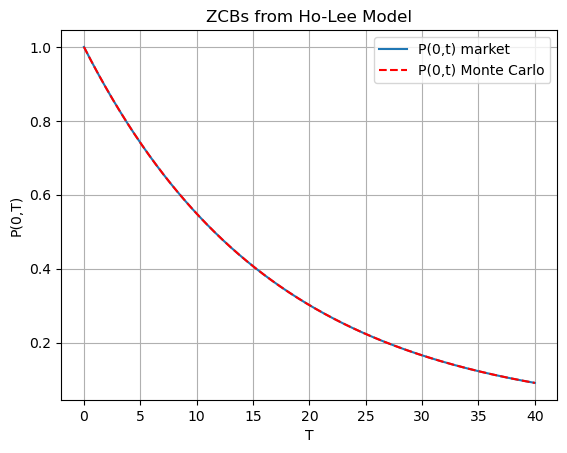

In [1]:

import numpy as np
import matplotlib.pyplot as plt

def f0T(t,P0T):
    # time-step needed for differentiation
    dt = 0.01    
    expr = - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    return expr

def GeneratePathsHoLeeEuler(NoOfPaths,NoOfSteps,T,P0T,sigma):    
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.01,P0T)
    theta = lambda t: (f0T(t+dt,P0T)-f0T(t-dt,P0T))/(2.0*dt) + sigma**2.0*t 
     
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    R = np.zeros([NoOfPaths, NoOfSteps+1])
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    R[:,0]=r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + theta(time[i]) * dt + sigma* (W[:,i+1]-W[:,i])
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt)
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R,"M":M}
    return paths

def mainCalculation():
    NoOfPaths = 2500
    NoOfSteps = 500
       
    sigma = 0.002
        
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.06*T)
       
    # In this experiment we compare ZCB from the Market and Monte Carlo
    "Monte Carlo part"   
    T = 40
    paths= GeneratePathsHoLeeEuler(NoOfPaths,NoOfSteps,T,P0T,sigma)
    M = paths["M"]
    ti = paths["time"]
        
    # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression    
    P_t = np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        P_t[i] = np.mean(1.0/M[:,i])
   
    plt.figure(1)
    plt.grid()
    plt.xlabel('T')
    plt.ylabel('P(0,T)')
    plt.plot(ti,P0T(ti))
    plt.plot(ti,P_t,'--r')
    plt.legend(['P(0,t) market','P(0,t) Monte Carlo'])
    plt.title('ZCBs from Ho-Lee Model')
    
mainCalculation()







